Instead of using the complex TRL we code it from scratch, using lighting

https://github.com/rasbt/LLMs-from-scratch/blob/main/ch07/04_preference-tuning-with-dpo/dpo-from-scratch.ipynb

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

# ML
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Any, Callable, Dict, List, Literal, Optional, Tuple, Union
from einops import rearrange, reduce, repeat
from jaxtyping import Float, Int, Bool
from torch.utils.data import DataLoader

# Numeric
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# lightning
import lightning as pl
from lightning.pytorch.loggers.wandb import WandbLogger
from lightning.pytorch.loggers.csv_logs import CSVLogger


In [3]:
# Local
from reprpo.helpers.torch import clear_mem
from reprpo.gen import generation_test
import reprpo.silence
from reprpo.helpers.lightning_hist import read_metrics_csv, plot_hist

from reprpo.data.collate import DPODataCollatorWithPadding
from reprpo.train.dpo import compute_dpo_loss_batch, PL_DPO_MODEL

In [4]:
torch.set_float32_matmul_precision("medium")

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from reprpo.helpers.wandb import init_wandb

nb_name = init_wandb(__vsc_ipynb_file__)

In [5]:
from reprpo.train.lightning import TrainingArguments
from reprpo.train.dpo import DPOTrainingArguments

args = DPOTrainingArguments(lr=1e-5)
args

DPOTrainingArguments(model_name='google/gemma-2-2b', load_in_4bit=True, use_gradient_checkpointing=False, n_epochs=1, batch_size=8, lr=1e-05, weight_decay=0.0, n_samples=1800, max_length=128, max_prompt_length=64)

## Load model

In [6]:
from peft import LoraConfig, get_peft_model

from reprpo.models.load import load_model, print_trainable_parameters


model, tokenizer = load_model(args.model_name, load_in_4bit=args.load_in_4bit, attn_implementation='eager')

Not default chat template for google/gemma-2-2b. Setting to ALPACA_CHAT_TEMPLATE


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

### Load adapter

In [9]:
from peft.tuners import BOFTConfig, OFTConfig, LoraConfig, IA3Config

peft_config = LoraConfig(
    lora_alpha=16, 
    r=16,
    # use_rslora=True,
    # use_dora=True,
    task_type="CAUSAL_LM",
    target_modules= ["q_proj", "v_proj"], # gemma, llama
    # target_modules=[
        # FIXME: I'm not sure we can do LORA on the layer we are targeting?
        # "qkv_proj", "gate_up_proj", # in
        # "down_proj",  "o_proj", # out
        #             ], # PHI3
)
model = get_peft_model(model, peft_config, adapter_name=args.adapter_name)
print_trainable_parameters(model)
model

trainable params: 3194880 || all params: 1605398784 || trainable%: 0.19900849756716896


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Gemma2ForCausalLM(
      (model): Gemma2Model(
        (embed_tokens): Embedding(256000, 2304, padding_idx=0)
        (layers): ModuleList(
          (0-25): 26 x Gemma2DecoderLayer(
            (self_attn): Gemma2Attention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=2304, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (ReprPO): Identity()
                )
                (lora_A): ModuleDict(
                  (ReprPO): Linear(in_features=2304, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (ReprPO): Linear(in_features=16, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): Linear4

## Load data

In [10]:
from datasets import load_dataset


dataset2 = load_dataset("wassname/genie_dpo", name="code_easy")
print(dataset2)

# QC one row
r = dataset2['train'][0]
print(r['prompt'])
print('===')
print(r['chosen'])
print('---')
print(r['rejected'])

DatasetDict({
    train: Dataset({
        features: ['prompt', 'chosen', 'rejected', 'i'],
        num_rows: 1800
    })
    test: Dataset({
        features: ['prompt', 'chosen', 'rejected', 'i'],
        num_rows: 750
    })
})
Below is an instruction that describes a task, paired with an input that provides further context. Complete the request to the best of your ability.

### Instruction:
Write a python program that solves the following programming problem.

### Input:
Write a function that checks if an input is a positive integer.

### Response:

===
def is_positive_integer(number):
    return isinstance(number, int) and number > 0
---
def is_positive_integer(number):
    return isinstance(number, int) and number < 0


### Data Loader

We use huggingface datasets, which are pretokenized. So that we can stack

In [11]:
def tokenize_row(feature, tokenizer, args: TrainingArguments):
    """
    Tokenize a single row from a DPO specific dataset.

    see https://github.com/huggingface/trl/blob/main/trl/trainer/dpo_trainer.py#L784
    """
    batch = {}
    batch["chosen"] = tokenizer(feature["chosen"])["input_ids"]
    batch["rejected"] = tokenizer(feature["rejected"])["input_ids"]
    batch["prompt"] = tokenizer(feature["prompt"])["input_ids"]
    return batch

In [12]:
dataset3 = dataset2.map(lambda x: tokenize_row(x, tokenizer, args), batched=True, writer_batch_size=10)
dataset3['train'][0].keys()

Map:   0%|          | 0/1800 [00:00<?, ? examples/s]

Map:   0%|          | 0/750 [00:00<?, ? examples/s]

dict_keys(['prompt', 'chosen', 'rejected', 'i'])

In [13]:
custom_collate_fn = DPODataCollatorWithPadding(pad_token_id=tokenizer.pad_token_id, 
                                                  tokenizer=tokenizer,
                                                  max_length=args.max_length,
                                                  mask_prompt_tokens=True,
                                                  max_prompt_length=args.max_prompt_length,
                                                  #label_pad_token_id=-100
                                                  )



In [14]:


ds = dataset3
dl_train = DataLoader(ds['train'], batch_size=args.batch_size, collate_fn=custom_collate_fn)

dl_val = DataLoader(ds['test'], batch_size=args.batch_size, collate_fn=custom_collate_fn)

# QC
batch = next(iter(dl_train))
batch.keys()

dict_keys(['prompt', 'chosen', 'rejected', 'rejected_mask', 'chosen_mask'])

## Trainer

- https://lightning.ai/docs/pytorch/latest/notebooks/lightning_examples/text-transformers.html
- https://gist.github.com/wassname/e29d02b5026a531e13912cf768e6fdc8

In [16]:
max_steps = args.n_samples // args.batch_size
max_steps

In [17]:
ideal_batch_size = max(16, args.batch_size)
accumulate_grad_batches = np.ceil(ideal_batch_size/args.batch_size).astype(int)
print('accumulate_grad_batches', accumulate_grad_batches)
print('accumulated batch size', args.batch_size*accumulate_grad_batches)

print(f"epochs {args.n_samples//len(dl_train)}")

(2, 16)

In [18]:
from lightning.pytorch.callbacks import LearningRateMonitor
from reprpo.train.lightning import GenCallback

In [19]:
pl_model = PL_DPO_MODEL(model,
                 weight_decay=args.weight_decay,
                lr=args.lr,
                num_iterations=max_steps,
                batch_size=args.batch_size,
                )


In [20]:
# from reprpo.helpers.lightning_save import AdapterModelCheckpoint

# checkpoint_callback = AdapterModelCheckpoint(
#     verbose=True,
# )

In [21]:
from reprpo.helpers.lightning_existing_bnb import ExistingBitsandbytesPrecision

from accelerate.utils import CustomDtype
precision = ExistingBitsandbytesPrecision(
    # dtype=torch.bfloat16,
    # dtype=CustomDtype.INT4,
    dtype=torch.int8,
    default_dtype=torch.bfloat16,
)

In [22]:
timestamp = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")
save_dir = f"../outputs/{timestamp}/{nb_name}"
Path(save_dir).mkdir(exist_ok=True, parents=True)
trainer = pl.Trainer(
        max_steps=max_steps,
#         limit_val_batches=max_batches//5,
        gradient_clip_val=20,

        # accelerator='gpu',
        devices=1, 
        plugins=precision,
        
        # https://lightning.ai/docs/pytorch/stable/common/trainer.html
        # precision="bf16-true", # "32-true" "transformer-enginer
        log_every_n_steps=1,
        accumulate_grad_batches=accumulate_grad_batches,
        callbacks=[
            LearningRateMonitor(logging_interval='step'),
            GenCallback(every=max_steps//4),
            # checkpoint_callback
        ],
        logger=[
            CSVLogger(name=nb_name, save_dir=save_dir, flush_logs_every_n_steps=5),
            WandbLogger(name=nb_name, save_dir=save_dir),
        ],
        default_root_dir=save_dir,

        # too large, we will just save adapter
        enable_checkpointing=False, 

        # fast_dev_run=True,
    )

# train
trainer.fit(pl_model, dl_train, dl_val)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
wandb: Currently logged in as: wassname. Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type                 | Params | Mode 
--------------------------------------------------------
0 | _model | PeftModelForCausalLM | 1.6 B  | train
--------------------------------------------------------
3.2 M     Trainable params
1.6 B     Non-trainable params
1.6 B     Total params
6,421.595 Total estimated model params size (MB)
522       Modules in train mode
422       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Generated on batch 44
**Question**
```

<bos>tldr, markdown



        ### Instruction:
Q1: (100 words): Which Science Fiction Society would you prefer to live in and why? Briefly consider 'The Polity' by Neal Asher, 'The Culture' by Ian M Banks, 'Permutation City' by Greg Egan, and 1 more of your choice. Start with your conclusion, then give your reasoning.



    ### Response:


```
--------------------------------------------------------------------------------
**Adapter:`ReprPO` generation**`


/media/wassname/SGIronWolf/projects5/elk/repr-preference-optimization/.venv/lib/python3.9/site-packages/transformers/generation/utils.py:1850: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


`    I would prefer to live in the 'The Culture' by Ian M Banks. The reason is that the society is very advanced and the people are very intelligent. The society is very advanced and the people are very intelligent. The society is very advanced and the people are very intelligent. The society is very advanced and the people are very intelligent. The society is very advanced and the people are very intelligent. The society is very advanced and the people are very intelligent. The society is very advanced and the people are very intelligent. The society is very advanced and the people are very intelligent. The society is very advanced and the people are very intelligent`
--------------------------------------------------------------------------------
**Adapter:`None` generation**`
`    I would prefer to live in the 'The Culture' by Ian M Banks. The reason is that the 'The Culture' is a society that is based on the idea of 'The Culture' which is a society that is based on the idea of 'The

Validation: |          | 0/? [00:00<?, ?it/s]

**Question**
```

<bos>tldr, markdown



        ### Instruction:
Q1: (100 words): Which Science Fiction Society would you prefer to live in and why? Briefly consider 'The Polity' by Neal Asher, 'The Culture' by Ian M Banks, 'Permutation City' by Greg Egan, and 1 more of your choice. Start with your conclusion, then give your reasoning.



    ### Response:


```
--------------------------------------------------------------------------------
**Adapter:`ReprPO` generation**`
`    I would prefer to live in the 'The Culture' by Ian M Banks. The reason is that the 'The Culture' is a society that is based on the idea of 'The Culture' which is a society that is based on the idea of 'The Culture' which is a society that is based on the idea of 'The Culture' which is a society that is based on the idea of 'The Culture' which is a society that is based on the idea of 'The Culture' which is a society that is based on the idea of 'The Culture' which is a society that is based on the idea of 'The

`Trainer.fit` stopped: `max_steps=225` reached.


`    I would prefer to live in the 'The Culture' by Ian M Banks. The reason is that the 'The Culture' is a society that is based on the idea of 'The Culture' which is a society that is based on the idea of 'The Culture' which is a society that is based on the idea of 'The Culture' which is a society that is based on the idea of 'The Culture' which is a society that is based on the idea of 'The Culture' which is a society that is based on the idea of 'The Culture' which is a society that is based on the idea of 'The`
--------------------------------------------------------------------------------


In [23]:
# save as regular adapter only

model.save_pretrained(
    save_dir+'-adapter',
)

In [24]:
model.config

Gemma2Config {
  "_name_or_path": "google/gemma-2-2b",
  "architectures": [
    "Gemma2ForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "attn_logit_softcapping": 50.0,
  "bos_token_id": 2,
  "cache_implementation": "hybrid",
  "eos_token_id": 1,
  "final_logit_softcapping": 30.0,
  "head_dim": 256,
  "hidden_act": "gelu_pytorch_tanh",
  "hidden_activation": "gelu_pytorch_tanh",
  "hidden_size": 2304,
  "initializer_range": 0.02,
  "intermediate_size": 9216,
  "max_position_embeddings": 8192,
  "model_type": "gemma2",
  "num_attention_heads": 8,
  "num_hidden_layers": 26,
  "num_key_value_heads": 4,
  "pad_token_id": 0,
  "quantization_config": {
    "_load_in_4bit": true,
    "_load_in_8bit": false,
    "bnb_4bit_compute_dtype": "bfloat16",
    "bnb_4bit_quant_storage": "uint8",
    "bnb_4bit_quant_type": "nf4",
    "bnb_4bit_use_double_quant": true,
    "llm_int8_enable_fp32_cpu_offload": false,
    "llm_int8_has_fp16_weight": false,
    "llm_int8_skip_module

### Hist

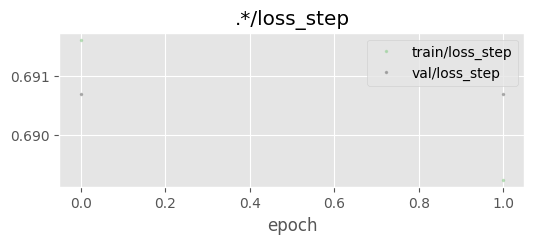

No matches for .*/acc.*
No matches for .*/auroc.*


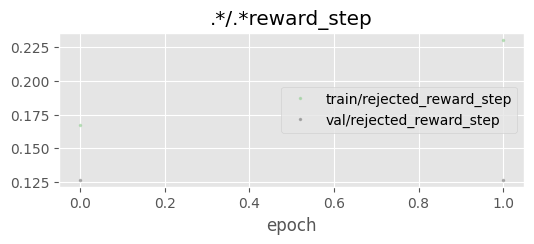

,lr-AdamW8bit,step,train/chosen_rewards_epoch,train/chosen_rewards_step,train/loss_epoch,train/loss_step,train/rejected_reward_epoch,train/rejected_reward_step,val/chosen_rewards_epoch,val/chosen_rewards_step,val/loss_epoch,val/loss_step,val/rejected_reward_epoch,val/rejected_reward_step
epoch,,,,,,,,,,,,,,
0.0,5.753446e-06,113,0.078003,0.198302,0.692645,0.691607,0.067948,0.167462,0.188006,0.175793,0.691585,0.690694,0.156725,0.126664
1.0,4.000000e-11,224,0.239702,0.308781,0.690134,0.689249,0.179300,0.230634,0.188006,0.175793,0.691585,0.690694,0.156725,0.126664


In [25]:
plt.style.use('ggplot')
import matplotlib
matplotlib.rcParams['figure.figsize'] = (6, 2)


df_hist = read_metrics_csv(trainer.logger.experiment.metrics_file_path).bfill().ffill()
plot_hist(df_hist, ['.*/loss_step', '.*/acc.*', '.*/auroc.*', '.*/.*reward_step'])
display(df_hist)

## Gen

In [42]:
model.cuda();
# generation_test(model, tokenizer, s="Q1: (30 words): Which Science Fiction Utopia is preferable and why? [The Polity, The Culture, Permutation City, 2 more]', ", max_new_tokens=64)

In [34]:
# model.prepare_inputs_for_generation??
# model.base_model.prepare_inputs_for_generation??

In [36]:
from reprpo.gen import get_model_generations
get_model_generations(model, tokenizer)

**Question**
```

<bos>tldr, markdown



        ### Instruction:
Q1: (100 words): Which Science Fiction Society would you prefer to live in and why? Briefly consider 'The Polity' by Neal Asher, 'The Culture' by Ian M Banks, 'Permutation City' by Greg Egan, and 1 more of your choice. Start with your conclusion, then give your reasoning.



    ### Response:


```
--------------------------------------------------------------------------------
**Adapter:`ReprPO` generation**`


/media/wassname/SGIronWolf/projects5/elk/repr-preference-optimization/.venv/lib/python3.9/site-packages/transformers/generation/utils.py:1850: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


RuntimeError: The size of tensor a (85) must match the size of tensor b (84) at non-singleton dimension 2

# SCRATCH

In [51]:
# from reprpo.helpers.shypothesis import shypothesis
# from reprpo.evaluate import evaluate_adapters
# from open_pref_eval.evaluation import evaluate_model
# from open_pref_eval.plot.radar import radar_plot

# N = 64
# datasets = [
            
#             # load_dataset('wassname/truthful_qa_dpo', split=f'validation[:{N}]', keep_in_memory=False),

#             # load_dataset('wassname/mmlu_dpo', name='elementary_mathematics', split=f'test[:{N}]', keep_in_memory=False), 

#             # # load_dataset('wassname/ethics_expression_dpo', name='commonsense', split=f'test[:{N}]', keep_in_memory=False),
#             # load_dataset('wassname/ethics_expression_dpo', name='utilitarianism', split=f'test[:{N}]', keep_in_memory=False),
#             # load_dataset('wassname/ethics_expression_dpo', name='justice', split=f'test[:{N}]', keep_in_memory=False),
#             # load_dataset('wassname/ethics_expression_dpo', name='deontology', split=f'test[:{N}]', keep_in_memory=False),      
#             load_dataset('wassname/genie_dpo', name='us_history_fiction', split=f'test[:{N}]', keep_in_memory=False),      
#             load_dataset('wassname/genie_dpo', name='code_hard', split=f'test[:{N}]', keep_in_memory=False),      
#             load_dataset('wassname/genie_dpo', name='code_easy', split=f'test[:{N}]', keep_in_memory=False),      
#             ]


# from open_pref_eval.scoring import score_ipo, score_weighted, score_dpo, score_weighted_prob, score_1st_diverg

# ress = {}
# for score_fn in [score_ipo, score_weighted, score_dpo, score_1st_diverg]:
#     clear_mem()
#     res, df_res2 = evaluate_model(model=model, 
#                                 tokenizer=tokenizer, 
#                                 datasets=datasets,
#                                 score_fn=score_fn,
#                                     batch_size=2,
#                                     bf16=True,
#                                     bf16_full_eval=True, 
#                                     torch_empty_cache_steps=100,)
#     print(score_fn.__name__)
#     display(res)
#     print('---')

#     ress[score_fn.__name__] = res

## Eval

In [52]:
from reprpo.helpers.shypothesis import shypothesis
from reprpo.evaluate import evaluate_adapters
from open_pref_eval.evaluation import evaluate_model
from open_pref_eval.plot.radar import radar_plot

N = 64
datasets = [
            
            load_dataset('wassname/truthful_qa_dpo', split=f'validation[:{N}]', keep_in_memory=False),

            load_dataset('wassname/mmlu_dpo', name='elementary_mathematics', split=f'test[:{N}]', keep_in_memory=False), 

            # load_dataset('wassname/ethics_expression_dpo', name='commonsense', split=f'test[:{N}]', keep_in_memory=False),
            load_dataset('wassname/ethics_expression_dpo', name='utilitarianism', split=f'test[:{N}]', keep_in_memory=False),
            load_dataset('wassname/ethics_expression_dpo', name='justice', split=f'test[:{N}]', keep_in_memory=False),
            # load_dataset('wassname/ethics_expression_dpo', name='deontology', split=f'test[:{N}]', keep_in_memory=False),      
            load_dataset('wassname/genie_dpo', name='us_history_fiction', split=f'test[:{N}]', keep_in_memory=False),      
            load_dataset('wassname/genie_dpo', name='code_hard', split=f'test[:{N}]', keep_in_memory=False),     
             load_dataset('wassname/genie_dpo', name='code_easy', split=f'test[:{N}]', keep_in_memory=False),     
            ]


clear_mem()
res, df_res2 = evaluate_model(model=model, 
                              tokenizer=tokenizer, 
                              datasets=datasets,
                                 batch_size=2,
                                 bf16=True,
                                 bf16_full_eval=True, 
                                 torch_empty_cache_steps=100,)
# radar_plot(res)
res

Map:   0%|          | 0/9 [00:00<?, ? examples/s]

Map:   0%|          | 0/9 [00:00<?, ? examples/s]

Map:   0%|          | 0/64 [00:00<?, ? examples/s]

Eval truthful_qa_dpo-validation[:64]:   0%|          | 0/16 [00:00<?, ?it/s]

Map:   0%|          | 0/64 [00:00<?, ? examples/s]

Eval mmlu_dpo-elementary_mathematics-test[:64]:   0%|          | 0/16 [00:00<?, ?it/s]

Map:   0%|          | 0/64 [00:00<?, ? examples/s]

Eval ethics_expression_dpo-utilitarianism-test[:64]:   0%|          | 0/16 [00:00<?, ?it/s]

Map:   0%|          | 0/64 [00:00<?, ? examples/s]

Eval ethics_expression_dpo-justice-test[:64]:   0%|          | 0/16 [00:00<?, ?it/s]

Map:   0%|          | 0/64 [00:00<?, ? examples/s]

Eval genie_dpo-us_history_fiction-test[:64]:   0%|          | 0/16 [00:00<?, ?it/s]

Map:   0%|          | 0/64 [00:00<?, ? examples/s]

Eval genie_dpo-code_hard-test[:64]:   0%|          | 0/16 [00:00<?, ?it/s]

Map:   0%|          | 0/64 [00:00<?, ? examples/s]

Eval genie_dpo-code_easy-test[:64]:   0%|          | 0/16 [00:00<?, ?it/s]

correct      prob   n
dataset                                        adapter                        
ethics_expression_dpo-justice-test[:64]        ReprPO   0.437500  0.493090  64
                                               base     0.453125  0.493818  64
ethics_expression_dpo-utilitarianism-test[:64] ReprPO   0.500000  0.505615  64
                                               base     0.546875  0.505299  64
genie_dpo-code_easy-test[:64]                  ReprPO   0.968750  0.510400  64
                                               base     0.953125  0.507295  64
genie_dpo-code_hard-test[:64]                  ReprPO   0.781250  0.504289  64
                                               base     0.750000  0.503659  64
genie_dpo-us_history_fiction-test[:64]         ReprPO   0.718750  0.509618  64
                                               base     0.640625  0.507785  64
mmlu_dpo-elementary_mathematics-test[:64]      ReprPO   0.703125  0.506532  64
                                               base     0.718750  0.505744  64
truthful_qa_dpo-validation[:64]                ReprPO   0.375000  0.479029  64
                                               base     0.390625  0.478893  64

adapter,ReprPO,base
dataset,,
ethics_expression_dpo-justice-test[:64],0.437500,0.453125
ethics_expression_dpo-utilitarianism-test[:64],0.500000,0.546875
genie_dpo-code_easy-test[:64],0.968750,0.953125
genie_dpo-code_hard-test[:64],0.781250,0.750000
genie_dpo-us_history_fiction-test[:64],0.718750,0.640625
mmlu_dpo-elementary_mathematics-test[:64],0.703125,0.718750
truthful_qa_dpo-validation[:64],0.375000,0.390625


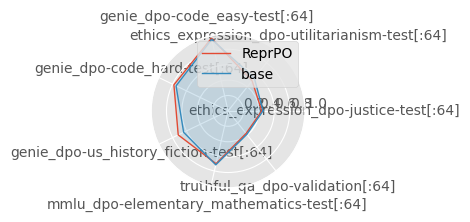

In [53]:
from open_pref_eval.plot.radar import radar_plot
df_res = df_res2.groupby(['dataset', 'adapter'], dropna=False)['correct'].mean().unstack()
radar_plot(df_res)
df_res

In [56]:
# print acc for journal
c  = df_res2.groupby(['adapter', 'dataset']).count().min().min()
print(f"⭐ run={nb_name}, N={c}")
print()
print(df_res[::-1].T[::-1].T.round(3).to_markdown()
      )
print()
print('args =', args)         

⭐ run=30_dpo_from_scratch, N=64

| dataset                                        |   base |   ReprPO |
|:-----------------------------------------------|-------:|---------:|
| truthful_qa_dpo-validation[:64]                |  0.391 |    0.375 |
| mmlu_dpo-elementary_mathematics-test[:64]      |  0.719 |    0.703 |
| genie_dpo-us_history_fiction-test[:64]         |  0.641 |    0.719 |
| genie_dpo-code_hard-test[:64]                  |  0.75  |    0.781 |
| genie_dpo-code_easy-test[:64]                  |  0.953 |    0.969 |
| ethics_expression_dpo-utilitarianism-test[:64] |  0.547 |    0.5   |
| ethics_expression_dpo-justice-test[:64]        |  0.453 |    0.438 |

args = DPOTrainingArguments(model_name='google/gemma-2-2b', load_in_4bit=True, use_gradient_checkpointing=False, n_epochs=1, batch_size=8, lr=1e-05, weight_decay=0.0, n_samples=1800, max_length=128, max_prompt_length=64, adapter_name='dpo')


In [76]:
df_res

adapter,ReprPO,base
dataset,,
ethics_expression_dpo-justice-test[:64],0.437500,0.453125
ethics_expression_dpo-utilitarianism-test[:64],0.500000,0.546875
genie_dpo-code_easy-test[:64],0.968750,0.953125
genie_dpo-code_hard-test[:64],0.781250,0.750000
genie_dpo-us_history_fiction-test[:64],0.718750,0.640625
mmlu_dpo-elementary_mathematics-test[:64],0.703125,0.718750
truthful_qa_dpo-validation[:64],0.375000,0.390625


In [78]:
print('did acc improve')
acc_pi = df_res[adapter_name]['genie_dpo-code_hard-test[:64]'].item()
acc_ref = df_res['base']['genie_dpo-code_hard-test[:64]'].item()
shypothesis('acc_pi>acc_ref', locals())


acc_pi_ood = df_res[adapter_name]['truthful_qa_dpo-validation[:64]'].item()
acc_ref_ood = df_res['base']['truthful_qa_dpo-validation[:64]'].item()
shypothesis('acc_pi_ood>acc_ref_ood', locals());

did acc improve
H		accₚᵢ > acc_ref
∴		0.781 > 0.750 ✅ [Δ = 0.031]

H		acc_π_ood > acc_ref_ood
∴		0.375 > 0.391 ❌ [Δ = -0.016]



In [69]:
print('did coherence improve?, (measured by mean prob per token) higher is better')
r = df_res2.groupby(['adapter', 'dataset'], dropna=False)['_chosen_logps'].mean().unstack()
r = np.exp(r)
display(r)

coherency_pi = float(r.T[adapter_name]['genie_dpo-code_easy-test[:64]'])
coherency_ref = float(r.T['base']['genie_dpo-code_easy-test[:64]'])
shypothesis('coherency_pi>coherency_ref', locals());

did coherence improve?, (measured by mean prob per token) higher is better


dataset,ethics_expression_dpo-justice-test[:64],ethics_expression_dpo-utilitarianism-test[:64],genie_dpo-code_easy-test[:64],genie_dpo-code_hard-test[:64],genie_dpo-us_history_fiction-test[:64],mmlu_dpo-elementary_mathematics-test[:64],truthful_qa_dpo-validation[:64]
adapter,,,,,,,
ReprPO,1.785415e-15,7.247447e-20,4.067215e-10,0.0,1.624249e-39,3.559673e-11,9.389750e-18
base,2.576741e-15,8.916723e-20,2.513779e-11,0.0,2.014787e-41,5.361446e-11,1.325668e-17


H		coherencyₚᵢ > coherency_ref
∴		0.0 > 0.0 ❌ [Δ = 0]



In [71]:
coherency_pi>coherency_ref

True

In [73]:

# print('are we biased by the length of the string? Ideally no correlation')
# a, b = df_res2['_l_chosen'], df_res2['_l_rejected']
# x = (a-b)/(a+b)
# plt.plot(x, df_res2['_logratio'], 'o')
# plt.xlabel('chosen longer')
# plt.ylabel('chosen more likely')

# # Damn this is not ideal....
# a = df_res2['_l_chosen'] / df_res2['_l_rejected']
# b = df_res2['prob']

# m = np.isfinite(a) & np.isfinite(b)
# a = a[m]
# b = b[m]
# corr_length = np.corrcoef(a, b)[1,0]
# print(f'{corr_length:.2f} (0 is ideal) correlation between length ratio and prob:')
# shypothesis('corr_length<0.25', locals())


# print(f'is the ds bised? {a.mean()/b.mean():.2f} (1 is ideal)')
# a=df_res2['prob']>0
# b=x>=0
# acc_bad = (a==b).mean()
# print(f'{acc_bad:.2%} (0.5 is ideal) how often does it accurately pick the longer one :( ')

# shypothesis('acc_bad<0.75', locals())